In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from optuna.exceptions import ExperimentalWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ExperimentalWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import numpy as np
import pandas as pd
import time

from pyspark.sql import SparkSession
from replay.utils.session_handler import get_spark_session, State

from replay.models import UCB, Wilson, RandomRec, LinUCB
from replay.experimental.scenarios.movielens_wrapper.replay_offline import OBPOfflinePolicyLearner
from replay.experimental.scenarios.movielens_wrapper.MIPS import MIPS
from replay.experimental.scenarios.movielens_wrapper.dataset import MovielensBanditDataset
from replay.experimental.scenarios.movielens_wrapper.utils import get_est_rewards_by_reg, bandit_subset

import obp
from obp.dataset import OpenBanditDataset
from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust,
    SelfNormalizedInverseProbabilityWeighting,
    SelfNormalizedDoublyRobust,
    MarginalizedInverseProbabilityWeighting,
)

'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


In [4]:
spark = State(get_spark_session()).session
spark.sparkContext.setLogLevel('ERROR')

24/09/10 21:03:22 WARN Utils: Your hostname, sudakovcom-MS-7D48 resolves to a loopback address: 127.0.1.1; using 10.255.173.26 instead (on interface enp3s0)
24/09/10 21:03:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/10 21:03:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/10 21:03:23 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


Lets define OpenBanditDataset class with random policy. For the purpose of demonstration we won't use the whole dataset but only subset of size 10000.

In [5]:
from rs_datasets import MovieLens

data = MovieLens("1m")
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [6]:
dataset = MovielensBanditDataset(data)

In [7]:
dataset.item_features.show(5)

+--------+-------+------+-----------+----------+-----+---------+---------+-----+---------+-------+------+-------+-------+--------+---+------+-------+------+
|item_idx|Mystery|Action|Documentary|Children's|Drama|Adventure|Film-Noir|Crime|Animation|Fantasy|Comedy|Western|Romance|Thriller|War|Sci-Fi|Musical|Horror|
+--------+-------+------+-----------+----------+-----+---------+---------+-----+---------+-------+------+-------+-------+--------+---+------+-------+------+
|      29|      0|     0|          0|         1|    0|        0|        0|    0|        1|      0|     1|      0|      0|       0|  0|     0|      0|     0|
|     393|      0|     0|          0|         1|    0|        1|        0|    0|        0|      1|     0|      0|      0|       0|  0|     0|      0|     0|
|     648|      0|     0|          0|         0|    0|        0|        0|    0|        0|      0|     1|      0|      1|       0|  0|     0|      0|     0|
|    1574|      0|     0|          0|         0|    1|    

In [8]:
dataset.user_features.show(5)

+--------+--------------+--------------+--------------+--------------+------------+--------+--------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|user_idx|agegroup_20-29|agegroup_30-39|agegroup_40-49|agegroup_51-60|agegroup_<20|gender_F|gender_M|occupation_0|occupation_1|occupation_2|occupation_3|occupation_4|occupation_5|occupation_6|occupation_7|occupation_8|occupation_9|occupation_10|occupation_11|occupation_12|occupation_13|occupation_14|occupation_15|occupation_16|occupation_17|occupation_18|occupation_19|occupation_20|
+--------+--------------+--------------+--------------+--------------+------------+--------+--------+------------+------------+------------+------------+------------+------------+------------+------------+------------+----------

In [9]:
dataset.log.show(5)

+--------+--------+---------+-------------------+
|user_idx|item_idx|relevance|          timestamp|
+--------+--------+---------+-------------------+
|    4131|      43|        1|2001-01-01 01:12:40|
|    4131|     585|        1|2001-01-01 01:35:09|
|    4131|     461|        1|2001-01-01 01:32:48|
|    4131|     105|        1|2001-01-01 01:04:35|
|    4131|      47|        1|2001-01-07 02:38:11|
+--------+--------+---------+-------------------+
only showing top 5 rows



In [10]:
dataset.context

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [11]:
dataset.action_context

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [12]:
bandit_feedback_train, bandit_feedback_test = dataset.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True)

print(bandit_feedback_train["n_rounds"])
print(bandit_feedback_test["n_rounds"])

100%|██████████| 1113/1113 [00:00<00:00, 4977.61it/s]


700144
1113


In [13]:
bandit_feedback_train.keys()

dict_keys(['log', 'item_features', 'user_features', 'n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context'])

The keys of the dictionary are as follows.
- n_rounds: number of rounds, data size of the logged bandit data;
- n_actions: number of actions $|\mathcal{A}|$;
- action: action variables sampled by the behavior policy;
- position: positions where actions are recommended, there are three positions in the ZOZOTOWN rec interface;
- reward: binary reward variables, click indicators;
- pscore: action choice probabilities by the behavior policy, propensity scores;
- context: context vectors such as user-related features and user-item affinity scores;
- action_context: item-related context vectors

In [14]:
#Define replay model
model_1 = UCB(exploration_coef =2.0, sample= False, seed= 123)
model_2 = LinUCB(eps = 10.0, alpha = 1.0, regr_type = 'disjoint')
model_3 = RandomRec(seed=42)

#Define learner which connects OBP data format with replay
learner_1 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_1,
                                    len_list=dataset.len_list,) #len_list is the number of predicted items per user
learner_2 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_2,
                                    len_list=dataset.len_list,) #len_list is the number of predicted items per user

learner_3 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_3,
                                    len_list=dataset.len_list,)

**RePlayOfflinePolicyLearner** has the following methods
- *fit(action, reward, timestamp, context, action_context)*;
- *predict(n_rounds, context)* (context can be None thus n_rounds is **required**);
- *optimize(bandit_feedback, val_size, param_borders, criterion, budget, new_study)*

In [15]:
bandit_feedback_train['log'].show(3)

+--------+--------+---------+-------------------+
|user_idx|item_idx|relevance|          timestamp|
+--------+--------+---------+-------------------+
|    3021|     366|        1|2000-11-22 06:03:07|
|    3021|      37|        1|2000-11-22 06:03:36|
|    3021|       6|        1|2000-11-22 06:04:11|
+--------+--------+---------+-------------------+
only showing top 3 rows



In [16]:
#Fit replay model inside our learner
learner_1.fit(bandit_feedback_train)
learner_2.fit(bandit_feedback_train)
learner_3.fit(bandit_feedback_train)

In [17]:
estimated_rewards_by_reg_model = get_est_rewards_by_reg(dataset.n_actions,
                                                        dataset.len_list,
                                                        bandit_feedback_train,
                                                        bandit_feedback_test)

When we get distribution over actions - we can run any evaluation procedure from the OBP. Here we use three estimators
- *IPW*: Average rewards with importance weights
- *DM*: Average predicted rewards using the classifier
- *DR*: Combination of the above methods with zero bias and lower variance

Also, we can construct confidence intervals for each of these methods.

In [18]:
bandit_feedback_test['log'].show(100)

+--------+--------+---------+-------------------+
|user_idx|item_idx|relevance|          timestamp|
+--------+--------+---------+-------------------+
|    3021|     186|        1|2000-11-22 06:17:21|
|    2008|      18|        1|2000-11-22 06:12:29|
|    3773|    1860|        1|2000-11-22 06:18:50|
|     471|      73|        1|2001-03-22 06:04:35|
|    2207|      18|        1|2000-12-04 04:17:13|
|    3599|     172|        0|2000-11-22 06:26:16|
|    1310|     484|        1|2000-11-23 01:55:04|
|     492|    1569|        1|2000-11-22 07:25:15|
|     715|     471|        1|2000-11-23 21:04:59|
|    1304|     748|        1|2000-11-22 07:49:58|
|       4|     787|        1|2000-11-26 01:46:20|
|     706|    1631|        1|2000-11-22 21:23:40|
|    1517|    3060|        1|2000-12-20 08:47:12|
|     210|    1925|        1|2002-11-08 05:47:44|
|    2857|     471|        1|2000-11-23 05:48:57|
|    1746|     484|        1|2000-11-22 22:07:35|
|    3718|      18|        1|2000-11-26 06:20:52|


In [19]:
def get_dist(learner):
    all_action_dist = np.zeros((bandit_feedback_test["n_rounds"], dataset.n_actions, dataset.len_list))
    batch_size = 300
    num_batchs = bandit_feedback_test["n_rounds"] // batch_size
    for i in range(num_batchs+1):
        j = min((i+1)*batch_size, bandit_feedback_test["n_rounds"])
        bandit_feedback_subset = bandit_subset([i*batch_size, j], bandit_feedback_test) #The first parameter is a slice of subset [a, b]
        print(type(bandit_feedback_subset["log"].select('user_idx')))
        print(bandit_feedback_subset["log"].select('user_idx').count())
        action_dist = learner.predict(bandit_feedback_subset["n_rounds"], bandit_feedback_subset["log"].select('user_idx'))
        all_action_dist[i*batch_size:j, :, :] = action_dist
    return all_action_dist

In [20]:
#Predict distribution over actions: shape (n_rounds, n_actions, len_list)
import time
start = time.time()
learner_action_dist_1 = get_dist(learner_1)
print(time.time() - start)

start = time.time()
learner_action_dist_2 = get_dist(learner_2)
print(time.time() - start)

start = time.time()
learner_action_dist_3 = get_dist(learner_3)
print(time.time() - start)

<class 'pyspark.sql.dataframe.DataFrame'>
300
<class 'pyspark.sql.dataframe.DataFrame'>
300
<class 'pyspark.sql.dataframe.DataFrame'>
300
<class 'pyspark.sql.dataframe.DataFrame'>
213
1.6013050079345703
<class 'pyspark.sql.dataframe.DataFrame'>
300
+--------+--------+-----------------+-------------------+
|user_idx|item_idx|        relevance|      Softmax_Score|
+--------+--------+-----------------+-------------------+
|      46|    2843|17.32050807568877|0.05000000000000002|
|      46|    3676|17.32050807568877|0.05000000000000002|
|      46|    3657|17.32050807568877|0.05000000000000002|
|      46|    3375|17.32050807568877|0.05000000000000002|
|      46|    3528|17.32050807568877|0.05000000000000002|
|      46|    3682|17.32050807568877|0.05000000000000002|
|      46|    3687|17.32050807568877|0.05000000000000002|
|      46|    3689|17.32050807568877|0.05000000000000002|
|      46|    3690|17.32050807568877|0.05000000000000002|
|      46|    3691|17.32050807568877|0.0500000000000000

/home/sudakovcom/Desktop/RePlayHDILab2024/replay/models/base_rec.py:1515: SparkCollectToMasterWarning: Prediction with sampling performs spark to pandas convertion to master node, this may lead to OOM exception for large item catalogue.
  warnings.warn(


<class 'pyspark.sql.dataframe.DataFrame'>
300


/home/sudakovcom/Desktop/RePlayHDILab2024/replay/models/base_rec.py:1515: SparkCollectToMasterWarning: Prediction with sampling performs spark to pandas convertion to master node, this may lead to OOM exception for large item catalogue.
  warnings.warn(


<class 'pyspark.sql.dataframe.DataFrame'>
300


/home/sudakovcom/Desktop/RePlayHDILab2024/replay/models/base_rec.py:1515: SparkCollectToMasterWarning: Prediction with sampling performs spark to pandas convertion to master node, this may lead to OOM exception for large item catalogue.
  warnings.warn(


<class 'pyspark.sql.dataframe.DataFrame'>
213
0.9774625301361084


/home/sudakovcom/Desktop/RePlayHDILab2024/replay/models/base_rec.py:1515: SparkCollectToMasterWarning: Prediction with sampling performs spark to pandas convertion to master node, this may lead to OOM exception for large item catalogue.
  warnings.warn(


In [21]:
def run_exp(learner_action_dist):
    Vs = []
    CIs = []

    # for n_size in [50000, 100000, 200000, 300000, bandit_feedback_test["n_rounds"]]:
    for n_size in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, bandit_feedback_test["n_rounds"]]:
        start = time.time()
        bandit_feedback_subset = bandit_subset([0, n_size], bandit_feedback_test) #The first parameter is a slice of subset [a, b]

        ope = OffPolicyEvaluation(
            bandit_feedback=bandit_feedback_subset,
            ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), SelfNormalizedDoublyRobust(),
                            SelfNormalizedInverseProbabilityWeighting(),]
        )

        estimated_rewards_by_reg_model_subset = estimated_rewards_by_reg_model[0: n_size, :, :]
        
        action_dist = learner_action_dist[:n_size, :, :]
        estimated_policy_value = ope.estimate_policy_values(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
        )

        estimated_ci = ope.estimate_intervals(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
            n_bootstrap_samples=10000,
            random_state=12345,)
        end = time.time()
        print("n_size =", n_size, "time: ", end-start)
        Vs.append(estimated_policy_value)
        CIs.append(estimated_ci)
    return(Vs, CIs)

In [22]:
Vs_1, CIs_1 = run_exp(learner_action_dist_1)

n_size = 100 time:  0.4997258186340332
n_size = 200 time:  0.48468589782714844
n_size = 300 time:  0.5819211006164551
n_size = 400 time:  0.5743474960327148
n_size = 500 time:  0.542926549911499
n_size = 600 time:  0.7949297428131104
n_size = 700 time:  0.7239253520965576
n_size = 800 time:  0.7119367122650146
n_size = 900 time:  0.6935811042785645
n_size = 1000 time:  0.6663405895233154
n_size = 1113 time:  1.1578857898712158


In [23]:
Vs_2, CIs_2 = run_exp(learner_action_dist_2)

n_size = 100 time:  0.44315552711486816
n_size = 200 time:  0.5002737045288086
n_size = 300 time:  0.5948612689971924
n_size = 400 time:  0.557103157043457
n_size = 500 time:  0.5137505531311035
n_size = 600 time:  0.7655370235443115
n_size = 700 time:  0.74112868309021
n_size = 800 time:  0.7102518081665039
n_size = 900 time:  0.6685299873352051
n_size = 1000 time:  0.6526999473571777
n_size = 1113 time:  1.1555588245391846


In [24]:
Vs_3, CIs_3 = run_exp(learner_action_dist_3)

n_size = 100 time:  0.4426274299621582
n_size = 200 time:  0.48202037811279297
n_size = 300 time:  0.5714445114135742
n_size = 400 time:  0.5333497524261475
n_size = 500 time:  0.5066161155700684
n_size = 600 time:  0.7499370574951172
n_size = 700 time:  0.7358512878417969
n_size = 800 time:  0.70285964012146
n_size = 900 time:  0.6740455627441406
n_size = 1000 time:  0.6470086574554443
n_size = 1113 time:  1.1360688209533691


In [25]:
import matplotlib.pyplot as plt
def plot_disjoint_res(Vs, CIs, model): 
    fig, ax = plt.subplots(4, figsize=(10, 10))

    # x = [50000, 100000, 200000, 300000, bandit_feedback_test["n_rounds"]]
    x = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i = 0
    for name in ['ipw', 'dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax[i].plot(x, y_est, '-', label=name, color = colors[i])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        #ax.plot(x, y, 'o', color='tab:brown')
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()

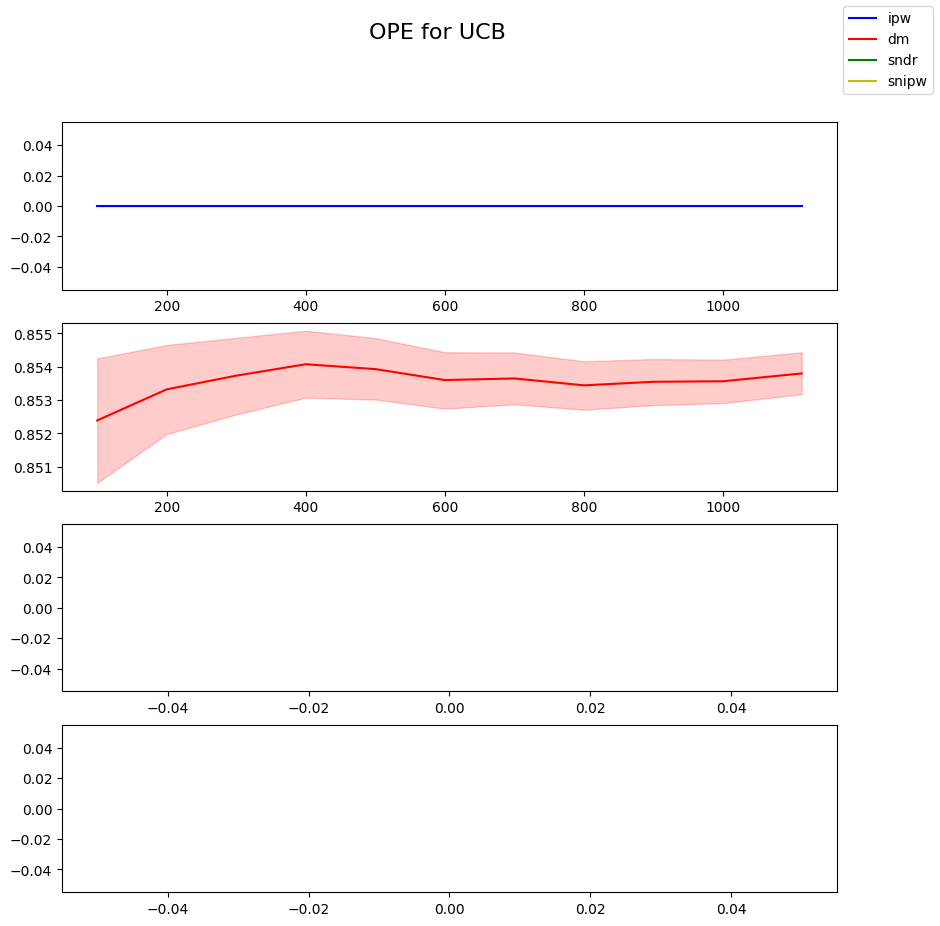

In [26]:
plot_disjoint_res(Vs_1, CIs_1, 'UCB')

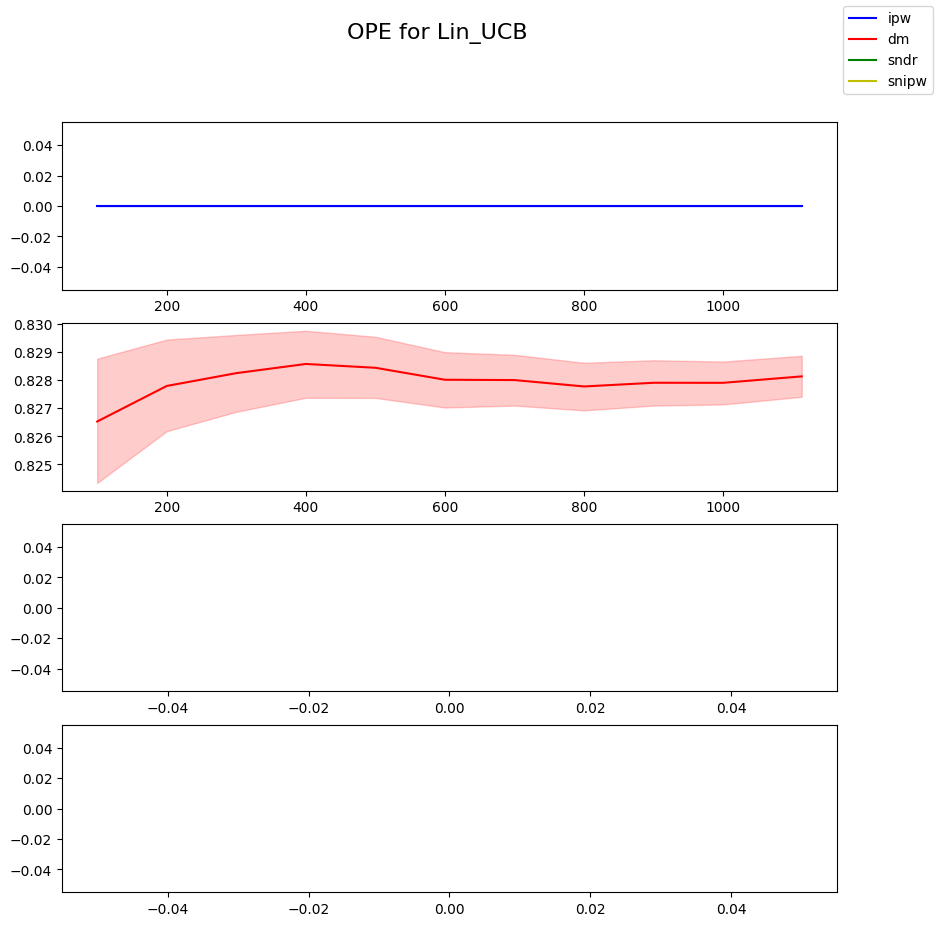

In [27]:
plot_disjoint_res(Vs_2, CIs_2, 'Lin_UCB')

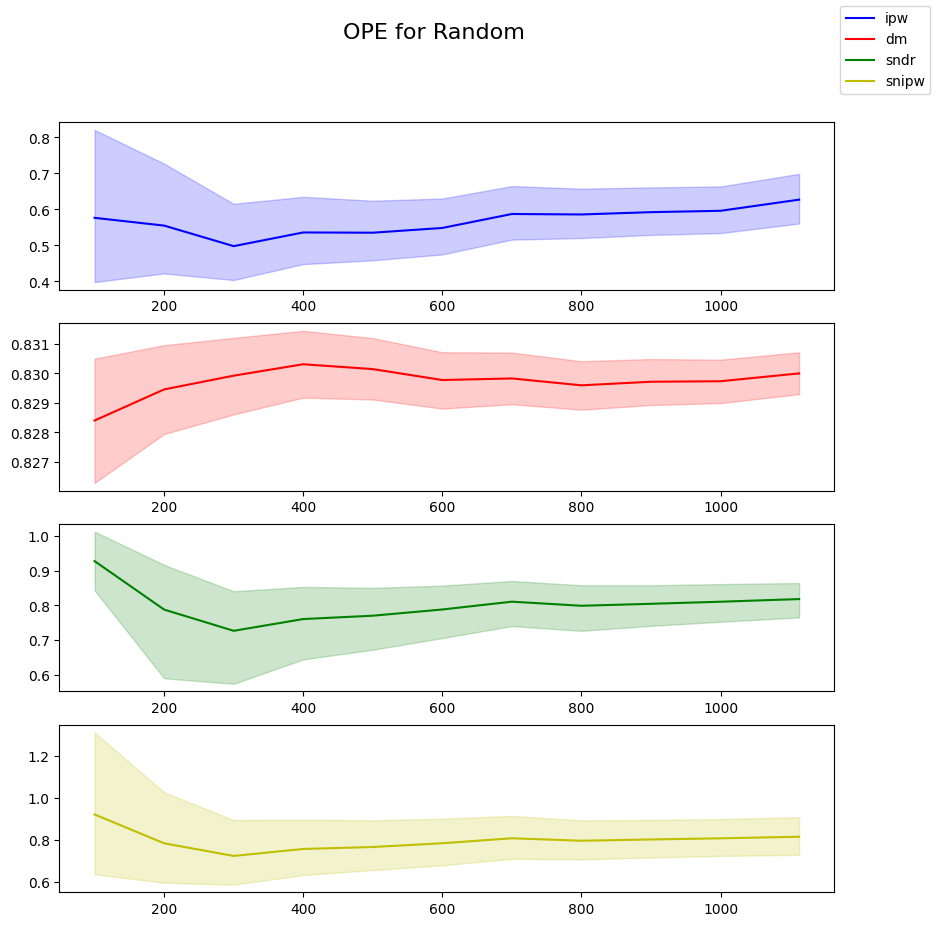

In [28]:
plot_disjoint_res(Vs_3, CIs_3, 'Random')

In [29]:
out_str = f"Scores for UCB true"
for key, val in Vs_1[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for UCB true ipw : 0.000, dm : 853.795, sndr : nan, snipw : nan


In [30]:
out_str = f"Scores for Lin_UCB true"
for key, val in Vs_2[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for Lin_UCB true ipw : 0.000, dm : 828.125, sndr : nan, snipw : nan


In [31]:
out_str = f"Scores for random true"
for key, val in Vs_3[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for random true ipw : 627.394, dm : 829.998, sndr : 817.994, snipw : 815.213


In [32]:
print("USB all")
print(Vs_1)

USB all
[{'ipw': 0.0, 'dm': 0.852383423143284, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8533258013006426, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8537274138783003, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8540750675695918, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8539293056875904, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8535978565799572, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8536463330482159, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8534367035411664, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8535431825891604, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8535588447107666, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8537948981890854, 'sndr': nan, 'snipw': nan}]


In [33]:
print("Lin USB all")
print(Vs_2)

Lin USB all
[{'ipw': 0.0, 'dm': 0.8265170365106271, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8277935240176646, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8282388735709983, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8285720526278354, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8284372068169553, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8280084656388756, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8279972481400009, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8277671987768848, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8278975486484702, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8278953867042512, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8281252302931579, 'sndr': nan, 'snipw': nan}]


In [34]:
print("Random all")
print(Vs_3)

Random all
[{'ipw': 0.5772802247523167, 'dm': 0.8284014241986849, 'sndr': 0.9274079476588158, 'snipw': 0.9221395074733146}, {'ipw': 0.5556874970314517, 'dm': 0.8294649375191172, 'sndr': 0.7887940419491761, 'snipw': 0.7844722501349195}, {'ipw': 0.4973670174562157, 'dm': 0.8299203324514864, 'sndr': 0.7262266464260667, 'snipw': 0.7224817302476129}, {'ipw': 0.5353981618012638, 'dm': 0.8303127766763804, 'sndr': 0.7599984203002396, 'snipw': 0.755748161069213}, {'ipw': 0.5351005601173675, 'dm': 0.8301493376473312, 'sndr': 0.7699727479825083, 'snipw': 0.7656572425014774}, {'ipw': 0.5484085975102648, 'dm': 0.8297755090712965, 'sndr': 0.7876455265625272, 'snipw': 0.783722344964383}, {'ipw': 0.587086013876196, 'dm': 0.8298297005076906, 'sndr': 0.8101339851262199, 'snipw': 0.8072052560461007}, {'ipw': 0.5859684175879635, 'dm': 0.8295934977129735, 'sndr': 0.7984660270977452, 'snipw': 0.7957149839463318}, {'ipw': 0.5922337878325235, 'dm': 0.8297143659531099, 'sndr': 0.8041688048372168, 'snipw': 0.80

In [35]:
print("Estimated confidence intervals UCB:")
print(pd.DataFrame(CIs_1[-1]).to_string())
print("Estimated confidence intervals Lin UCB:")
print(pd.DataFrame(CIs_2[-1]).to_string())
print("Estimated confidence intervals Random:")
print(pd.DataFrame(CIs_3[-1]).to_string())

Estimated confidence intervals UCB:
                  ipw        dm  sndr  snipw
mean              0.0  0.853796   NaN    NaN
95.0% CI (lower)  0.0  0.853172   NaN    NaN
95.0% CI (upper)  0.0  0.854429   NaN    NaN
Estimated confidence intervals Lin UCB:
                  ipw        dm  sndr  snipw
mean              0.0  0.828126   NaN    NaN
95.0% CI (lower)  0.0  0.827401   NaN    NaN
95.0% CI (upper)  0.0  0.828857   NaN    NaN
Estimated confidence intervals Random:
                       ipw        dm      sndr     snipw
mean              0.627196  0.829999  0.817891  0.814956
95.0% CI (lower)  0.560890  0.829296  0.765011  0.728801
95.0% CI (upper)  0.698833  0.830713  0.864162  0.908038
